In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_noisy_scc00301.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_noisy_scc00366.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_cropped_scc00080.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_scaled_scc00213.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_scaled_scc00157.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_noisy_scc00278.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_noisy_scc00313.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_cropped_scc00184.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_noisy_scc00253.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_scaled_scc00115.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_noisy_scc00003.jpg
/kaggle/input/skin-cancer-dataset-multiclass/aug/aug_scc/aug_scaled_scc00219.jpg
/kaggle/input/skin-cancer-datase

In [2]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.3 MB/s eta 0:00:00


In [3]:
!pip install --upgrade wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 65.5 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.19.1
    Uninstalling wandb-0.19.1:
      Successfully uninstalled wandb-0.19.1


## Import Libraries

In [4]:
import cv2 as cv
from skimage import segmentation
import cv2
import os
import gc
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryAUROC


# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.utils.class_weight import compute_class_weight


# For Image Models
import timm

import wandb

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Currently logged in as: mussum67 (mussum67-universitat-de-girona). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Configurations

In [6]:
# CONFIG = {
#     "seed": 42,
#     "epochs": 40,  # Increased epochs
#     "img_size": 224,
#     "model_name": "tf_efficientnet_b0_ns",
#     "train_batch_size": 32,
#     "valid_batch_size": 64,
#     "learning_rate": 2e-4,  # Slightly higher learning rate
#     "scheduler": 'CosineAnnealingLR',
#     "min_lr": 1e-6,
#     "T_max": 20,  # Adjusted for longer training duration
#     "weight_decay": 1e-6,
#     "fold": 0,
#     "n_fold": 5,
#     "n_accumulate": 1,
#     "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
#     "patience": 5,  # Add patience for early stopping
# }


## EFFICIENT_NET_CONFIGURATIONS


In [7]:
# CONFIG = {
#     "seed": 42,
#     "epochs": 30,  # Reduced to start with
#     "img_size": 224,
#     "model_name": "tf_efficientnet_b0_ns",
#     "train_batch_size": 32,
#     "valid_batch_size": 32,  # Match training batch size for faster validation
#     "learning_rate": 1e-4,  # Lower initial learning rate
#     "scheduler": 'CosineAnnealingWarmRestarts',  # Switch to warm restarts
#     "min_lr": 1e-6,
#     "T_max": 10,  # Adjusted for restarts
#     "weight_decay": 1e-4,  # Slightly higher regularization
#     "fold": 0,
#     "n_fold": 5,
#     "n_accumulate": 1,
#     "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
#     "patience": 5,
# }


## Swin_transformer_Configurations

In [8]:
# CONFIG = {
#     "seed": 42,
#     "epochs": 40,
#     "img_size": 224,
#     "model_name": "swin_tiny_patch4_window7_224",  # Smaller Swin Transformer
#     "train_batch_size": 16,  # Reduced batch size
#     "valid_batch_size": 16,  # Match training batch size
#     "learning_rate": 5e-5,
#     "scheduler": 'CosineAnnealingLR',
#     "min_lr": 1e-6,
#     "T_max": 10,
#     "weight_decay": 1e-4,
#     "fold": 0,
#     "n_fold": 5,
#     "n_accumulate": 2,  # Gradient accumulation
#     "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
#     "patience": 5,
# }


In [9]:
CONFIG = {
    "seed": 42,
    "epochs": 50,  # Reduced to prevent overfitting
    "img_size": 224,
    "model_name": "swin_tiny_patch4_window7_224",
    "train_batch_size": 16,
    "valid_batch_size": 16,
    "learning_rate": 1e-4,  # Initial learning rate
    "scheduler": 'ReduceLROnPlateau',  # Changed to ReduceLROnPlateau
    "min_lr": 1e-6,  # Minimum LR for scheduler
    "weight_decay": 1e-6,
    "fold": 0,
    "n_fold": 5,
    "n_accumulate": 2,  # Gradient accumulation
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "patience": 12,  # Patience for ReduceLROnPlateau
}


In [10]:
print(f"Device being used: {CONFIG['device']}")
print(f"CUDA available: {torch.cuda.is_available()}")


Device being used: cuda:0
CUDA available: True


## Reproducibility

In [11]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

## Data Loading

In [12]:
# Data Loading
classes = ['bcc', 'mel', 'scc']
image_dir_train = '/kaggle/input/skin-cancer-dataset-multiclass/train/train'

def load_data(image_dir, classes):
    data = []
    for i, c in enumerate(classes):
        class_dir = os.path.join(image_dir, c)
        if os.path.exists(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    data.append([os.path.join(class_dir, filename), c, i])
    return pd.DataFrame(data, columns=['image_path', 'label_name', 'label'])

df_train = load_data(image_dir_train, classes)

In [13]:
df_train

,image_path,label_name,label
0,/kaggle/input/skin-cancer-dataset-multiclass/t...,bcc,0
1,/kaggle/input/skin-cancer-dataset-multiclass/t...,bcc,0
2,/kaggle/input/skin-cancer-dataset-multiclass/t...,bcc,0
3,/kaggle/input/skin-cancer-dataset-multiclass/t...,bcc,0
4,/kaggle/input/skin-cancer-dataset-multiclass/t...,bcc,0
...,...,...,...
5077,/kaggle/input/skin-cancer-dataset-multiclass/t...,scc,2
5078,/kaggle/input/skin-cancer-dataset-multiclass/t...,scc,2
5079,/kaggle/input/skin-cancer-dataset-multiclass/t...,scc,2
5080,/kaggle/input/skin-cancer-dataset-multiclass/t...,scc,2


In [14]:
# df_train = load_data(image_dir_train, classes)

# # Check the first few rows of the DataFrame
# print(df_train.head())

# # Check if images with label 1 exist
# print("Images with label 1:")
# print(df_train[df_train['label'] == 2])


In [15]:
print(df_train['label'].value_counts())


label
1    2713
0    1993
2     376
Name: count, dtype: int64


## K-fold

In [16]:
from sklearn.model_selection import StratifiedKFold

def create_folds(df, num_splits=5):
    df["kfold"] = -1
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df.label)):
        df.loc[val_idx, "kfold"] = fold
    return df

# Add K-Folds to df_train
df_train = create_folds(df_train, num_splits=5)

## Sample Data Visualization

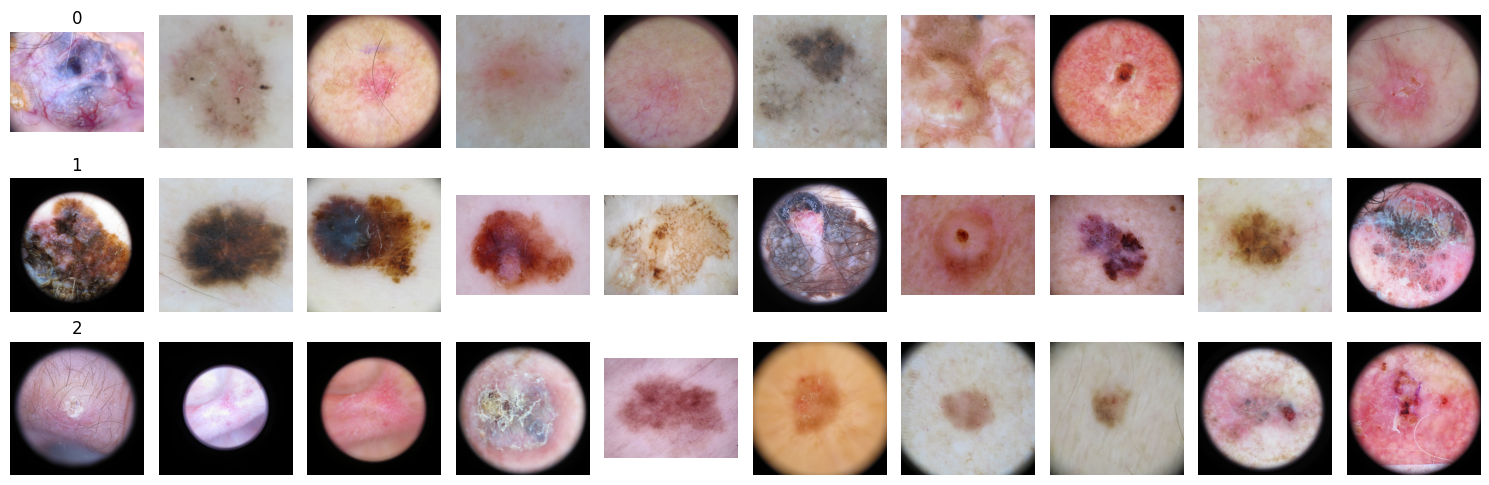

In [17]:
# Number of random images to select per class
num_images = 10

# Initialize a dictionary to store selected image paths by class
selected_images = {}

# Loop through each class and randomly sample 10 images
for c in df_train['label'].unique():
    class_images = df_train[df_train['label'] == c]  # Filter DataFrame by class
    sampled_images = class_images.sample(n=min(len(class_images), num_images))  # Randomly sample 10 images
    selected_images[c] = sampled_images['image_path'].tolist()

# Plot the randomly selected images
fig, axes = plt.subplots(len(selected_images), num_images, figsize=(15, 5))

for class_idx, c in enumerate(selected_images.keys()):
    for img_idx, img_path in enumerate(selected_images[c]):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
        ax = axes[class_idx, img_idx]
        ax.imshow(img_rgb)
        ax.axis('off')  # Hide axis for cleaner display
        if img_idx == 0:
            ax.set_title(c)  # Set class label as title on the first image of each row

plt.tight_layout()
plt.show()

In [18]:
class Preprocessing:
    """
       Preprocessing class. This class's purpose is to preprocess the images in the dataset.
    """

    def _hair_removal(self, img, se_width=11, se_height=1, n_orientations=8):
        # Input validation for structuring element dimensions
        if se_width % 2 == 0:
            raise ValueError(f"Structuring element width ({se_width}) must be odd")
        if se_height % 2 == 0:
            raise ValueError(f"Structuring element height ({se_height}) must be odd")

        # Convert the original image to grayscale if it has more than 1 channel
        if len(img.shape) == 3:
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            img_gray = img

        # Create tilted structuring elements
        base = np.zeros((se_width, se_width), dtype=np.uint8)
        for k in range(se_width // 2 - se_height // 2, se_width // 2 + se_height // 2 + 1):
            cv.line(base, (0, k), (se_width, k), 255)

        # Compute rotated structuring elements
        SEs = [base]
        angle_step = 180.0 / n_orientations
        for k in range(1, n_orientations):
            rotation_matrix = cv.getRotationMatrix2D((se_width / 2.0, se_width / 2.0), k * angle_step, 1.0)
            SE = cv.warpAffine(base, rotation_matrix, (se_width, se_width), flags=cv.INTER_NEAREST)
            SEs.append(SE)

        # Initialize sum of blackhat results
        sum_blackhats = np.zeros_like(img_gray, dtype=np.uint16)

        # Apply blackhat operation using each structuring element and accumulate results
        for SE in SEs:
            blackhat = cv.morphologyEx(img_gray, cv.MORPH_BLACKHAT, SE)
            sum_blackhats += blackhat

        # Normalize the sum of blackhats to the range 0-255 and convert to uint8
        cv.normalize(sum_blackhats, sum_blackhats, 0, 255, cv.NORM_MINMAX)
        sum_blackhats = sum_blackhats.astype(np.uint8)

        # Threshold the blackhat sum to create a binary mask for inpainting
        _, thresholded = cv.threshold(sum_blackhats, 0, 255, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)

        # Refine the mask using morphological opening to remove small components
        thresholded = cv.morphologyEx(thresholded, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3)))

        # Dilate the mask slightly to cover the hair regions more effectively
        thresholded = cv.dilate(thresholded, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))

        # Inpaint the original image using the created mask
        if len(img.shape) == 3:
            result = cv.inpaint(img, thresholded, 3, cv.INPAINT_NS)
        else:
            result = cv.inpaint(img_gray, thresholded, 3, cv.INPAINT_NS)

        return result
    
    def _color_constancy(self, img, power=5, gamma=1.4):
        """
        Apply color constancy to the input image using a power transformation and optional gamma correction.

        Parameters:
            img (numpy.ndarray): Input image.
            power (float): Power to use for the power transformation (default is 6).
            gamma (float, optional): Gamma value for gamma correction (default is 2.2).

        Returns:
            numpy.ndarray: Image with color constancy applied.
        """
        # Get the data type of the input image
        img_dtype = img.dtype

        # Apply gamma correction if gamma is provided
        if gamma is not None:
            img = img / 255.0  # Normalize to 0-1
            img = np.power(img, 1 / gamma)
            img = (img * 255).astype('float32')

        # Convert the image to float32 data type for further processing
        img = img.astype('float32')

        # Apply power transformation to the image
        img_power = np.power(img, power)

        # Calculate the mean of img_power along channels (0 and 1)
        rgb_vec = np.power(np.mean(img_power, axis=(0, 1)), 1 / power)

        # Calculate the L2 norm of rgb_vec
        rgb_norm = np.linalg.norm(rgb_vec)

        # Normalize rgb_vec to have unit length
        rgb_vec /= (rgb_norm + 1e-6)  # Added small value to avoid division by zero

        # Scale down rgb_vec to prevent overexposure (tuning parameter)
        scale_factor = 0.8  # Scale down the effect of rgb_vec
        rgb_vec = (1 / (rgb_vec * np.sqrt(3))) * scale_factor

        # Scale img using the adjusted color constancy vector
        img = img * rgb_vec
        img = np.clip(img, 0, 255)

        # Normalize the image to 0-255 if needed
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)

        return img.astype(img_dtype)

    
    def _roi(self, img, threshold=50):
        # Image dimensions
        h, w = img.shape[:2]
        
        # Get the minimum dimension to avoid index errors
        min_dim = min(h, w)
        
        # Calculate mean values along the diagonal
        diagonal_values = np.mean(img[np.arange(min_dim), np.arange(min_dim), :], axis=1)

        # Find the first and last points where the threshold is crossed
        above_threshold = np.where(diagonal_values >= threshold)[0]
        if above_threshold.size == 0:
            # If no diagonal value exceeds the threshold, return the original image
            return img
        
        first_cross = above_threshold[0]
        last_cross = above_threshold[-1]
        
        # Set the coordinates to crop the image
        y1 = max(0, first_cross)
        y2 = min(h, last_cross + 1)
        x1 = max(0, first_cross)
        x2 = min(w, last_cross + 1)
        
        # Crop the image using the calculated coordinates
        img_new = img[y1:y2, x1:x2, :]
        
        # Ensure the cropped image is not empty
        if img_new.shape[0] == 0 or img_new.shape[1] == 0:
            return img

        return img_new
    

    def _add_padd_to_image(self, img, padding_size):
        # Get the dimensions of the original image
        height_original, width_original = img.shape

        # Create a new larger image with black padding
        new_height = height_original + 2 * padding_size
        new_width = width_original + 2 * padding_size
        padding_image = np.zeros((new_height, new_width), dtype=np.uint8)

        # Calculate the position to place the original image in the center of the new image
        x_offset = padding_size
        y_offset = padding_size

        # Copy the original image into the center of the new image
        padding_image[y_offset:y_offset + height_original, x_offset:x_offset + width_original] = img

        return padding_image, height_original, width_original

    def _back_original_shape(self, eroded_mask, width_original, height_original, padding_size):
        # Back to the original shape
        crop_x_start = padding_size
        crop_x_end = padding_size + width_original
        crop_y_start = padding_size
        crop_y_end = padding_size + height_original

        # Crop the padded image to the original size
        cropped_mask = 255 - eroded_mask[crop_y_start:crop_y_end, crop_x_start:crop_x_end]

        return cropped_mask

    def _plot_results(self, img, image_file, hair_removed_image, roi_image, cn_hair_removed_image, segmented_image, cropped_mask_3_channels, final_image):
        # Create a figure with a larger size
        plt.figure(figsize=(14, 4))

        # Display the original image
        plt.subplot(1, 6, 1)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(f'Original: {image_file}', fontsize=5)
        plt.axis('off')

        # Display the hair-removed image
        plt.subplot(1, 6, 2)
        plt.imshow(cv.cvtColor(hair_removed_image, cv.COLOR_BGR2RGB))
        plt.title('Step 1: Hair Removal', fontsize=5)
        plt.axis('off')

        # Display the color-normalized image
        plt.subplot(1, 6, 3)
        plt.imshow(cv.cvtColor(cn_hair_removed_image, cv.COLOR_BGR2RGB))
        plt.title('Step 2: Color Normalization', fontsize=5)
        plt.axis('off')

        # Display the ROI image
        plt.subplot(1, 6, 4)
        plt.imshow(cv.cvtColor(roi_image, cv.COLOR_BGR2RGB))
        plt.title('Step 3: ROI Image', fontsize=5)
        plt.axis('off')

        # Display the eroded mask
        plt.subplot(1, 6, 5)
        plt.imshow(cv.cvtColor(cropped_mask_3_channels, cv.COLOR_BGR2RGB))
        plt.title('Step 4: Padding + Binary Mask', fontsize=5)
        plt.axis('off')

        # Display the final image
        plt.subplot(1, 6, 6)
        plt.imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))
        plt.title('Final Image', fontsize=5)
        plt.axis('off')

        # Adjust the spacing between subplots
        plt.tight_layout()
        plt.savefig("preprocessing.png")
        plt.show()

    def preprocess_image(self, img, image_file, plot_results):
        # Call the function to remove the hairs from the image
        hair_removed_image = self._hair_removal(img)
        # Call the function to normalize the colors
        cn_hair_removed_image = self._color_constancy(hair_removed_image)
        # Call the function to crop the images
        roi_image = self._roi(cn_hair_removed_image)

        # Apply Gaussian blur
        kernel_size = (5, 5)
        sigma_x = 0
        img_blurred = cv.GaussianBlur(roi_image, kernel_size, sigma_x)
        img_gray = cv.cvtColor(img_blurred, cv.COLOR_BGR2GRAY)

        # Define padding size
        padding_size = 50
        padding_image, height_original, width_original = self._add_padd_to_image(img_gray, padding_size)

        # Region growing algorithm
        seed = (0, 0)
        segmented_image = segmentation.flood_fill(padding_image, seed_point=seed, new_value=0, tolerance=30)

        # Apply the thresholding to create the binary mask
        mask = np.where(segmented_image == 0, 255, 0).astype(np.uint8)

        # Define the kernel for erosion
        kernel_size = 11
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # We remove small elements
        mask = cv.dilate(cv.erode(mask, kernel, iterations=5), kernel, iterations=5)

        # We dilate the mask
        eroded_mask = cv.dilate(mask, kernel, iterations=5)

        # Back to the original shape
        cropped_mask = self._back_original_shape(eroded_mask, width_original, height_original, padding_size)

        # Final output
        cropped_mask_3_channels = cv.cvtColor(cropped_mask, cv.COLOR_GRAY2BGR)
        final_image = 255 - (cropped_mask_3_channels * roi_image)

        # Plot results
        if plot_results:
            self._plot_results(img, image_file, hair_removed_image, roi_image, cn_hair_removed_image, segmented_image, cropped_mask_3_channels, final_image)

        return final_image

    def preprocess_image_ROI(self, img):
        roi_image = self._roi(img)

        # Apply Gaussian blur
        kernel_size = (5, 5)
        sigma_x = 0
        img_blurred = cv.GaussianBlur(roi_image, kernel_size, sigma_x)
        img_gray = cv.cvtColor(img_blurred, cv.COLOR_BGR2GRAY)

        # Define padding size
        padding_size = 50
        padding_image, height_original, width_original = self._add_padd_to_image(img_gray, padding_size)

        # Region growing algorithm
        seed = (0, 0)
        segmented_image = segmentation.flood_fill(padding_image, seed_point=seed, new_value=0, tolerance=30)

        # Apply the thresholding to create the binary mask
        mask = np.where(segmented_image == 0, 255, 0).astype(np.uint8)

        # Define the kernel for erosion
        kernel_size = 11
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # We remove small elements
        mask = cv.dilate(cv.erode(mask, kernel, iterations=5), kernel, iterations=5)

        # We dilate the mask
        eroded_mask = cv.dilate(mask, kernel, iterations=5)

        # Back to the original shape
        cropped_mask = self._back_original_shape(eroded_mask, width_original, height_original, padding_size)

        # Final output
        cropped_mask_3_channels = cv.cvtColor(cropped_mask, cv.COLOR_GRAY2BGR)
        final_image = 255 - (cropped_mask_3_channels * roi_image)

        return final_image

In [19]:
preprocessing = Preprocessing()

# for class_idx, c in enumerate(selected_images.keys()):
#     for img_idx, img_path in enumerate(selected_images[c]):
#         img = cv2.imread(img_path)
#         preprocessing.preprocess_image(img, img_path, True)

In [20]:
# # Initialize variables for mean and standard deviation calculation
# channel_sum, channel_squared_sum = np.zeros(3), np.zeros(3)
# num_images = len(df_train)  # Total number of images

# # Iterate through df_train
# for idx, row in df_train.iterrows():
#     img_path = row['image_path']
#     # Read the image
#     img = cv2.imread(img_path)

#     # Preprocess the image using your preprocessing function
#     prepoc_img = preprocessing.preprocess_image(img, img_path, plot_results=False)

#     # Convert the preprocessed image to a PyTorch tensor and normalize to [0, 1]
#     prepoc_img_tensor = torch.tensor(prepoc_img.transpose(2, 0, 1), dtype=torch.float32) / 255.0  # HWC to CHW

#     # Update channel sums
#     channel_sum += prepoc_img_tensor.mean(dim=[1, 2]).numpy()
#     channel_squared_sum += (prepoc_img_tensor**2).mean(dim=[1, 2]).numpy()

# # Calculate the mean and standard deviation
# mean = channel_sum / num_images
# stddev = np.sqrt(channel_squared_sum / num_images - mean**2)

# # Display the results
# print("Training Dataset Normalization:")
# print("Mean              :", mean)
# print("Standard Deviation:", stddev)


## Creating Dataset class

In [21]:
# class ISICDataset_for_Train(Dataset):
#     def __init__(self, df, transforms=None, preprocessor=None):
#         self.df_positive = df[df["label"] == 1].reset_index(drop=True)
#         self.df_negative = df[df["label"] == 0].reset_index(drop=True)
#         self.file_names_positive = self.df_positive['image_path'].values
#         self.file_names_negative = self.df_negative['image_path'].values
#         self.labels_positive = self.df_positive['label'].values
#         self.labels_negative = self.df_negative['label'].values
#         self.transforms = transforms
#         self.preprocessor = preprocessor  # Pass the Preprocessing object

#     def __len__(self):
#         return len(self.df_positive) * 2

#     def __getitem__(self, index):
#         # Select positive or negative samples with equal probability
#         if random.random() >= 0.5:
#             file_names = self.file_names_positive
#             labels = self.labels_positive
#         else:
#             file_names = self.file_names_negative
#             labels = self.labels_negative
        
#         index = index % len(file_names)

#         # Load the image
#         img_path = file_names[index]
#         try:
#             img = cv2.imread(img_path)
#             if img is None:
#                 raise ValueError(f"Image not found or invalid at path: {img_path}")
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         except Exception as e:
#             raise RuntimeError(f"Error loading image {img_path}: {e}")
        
#         label = int(labels[index])

#         # Apply the preprocessing pipeline
#         if self.preprocessor:
#             img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

#         # Apply additional transformations (if provided)
#         if self.transforms:
#             img = self.transforms(image=img)["image"]  # Albumentations expects 'image'

#         # Ensure the image has the correct shape for PyTorch (C, H, W)
#         if isinstance(img, np.ndarray):
#             img = np.transpose(img, (2, 0, 1))  # HWC to CHW
#         img_tensor = torch.tensor(img, dtype=torch.float32)
#         #label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
#         label_tensor = torch.tensor(label, dtype=torch.float32).view(1)  # Ensure shape [1]
#         # Add .unsqueeze(0)
#         #print(f"Image Tensor Shape: {img_tensor.shape}")
#         #print(f"Label Tensor Shape: {label_tensor.shape}")


#         return {
#             'image': img_tensor,
#             'label': label_tensor
#         }


# class ISICDataset(Dataset):
#     def __init__(self, df, transforms=None, preprocessor=None):
#         self.df = df
#         self.file_names = df['image_path'].values
#         self.labels = df['label'].values
#         self.transforms = transforms
#         self.preprocessor = preprocessor  # Pass the Preprocessing object

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         # Load the image
#         img_path = self.file_names[index]
#         try:
#             img = cv2.imread(img_path)
#             if img is None:
#                 raise ValueError(f"Image not found or invalid at path: {img_path}")
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         except Exception as e:
#             raise RuntimeError(f"Error loading image {img_path}: {e}")
        
#         label = int(self.labels[index])

#         # Apply the preprocessing pipeline
#         if self.preprocessor:
#             img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

#         # Apply additional transformations (if provided)
#         if self.transforms:
#             img = self.transforms(image=img)["image"]  # Albumentations expects 'image'

#         # Ensure the image has the correct shape for PyTorch (C, H, W)
#         if isinstance(img, np.ndarray):
#             img = np.transpose(img, (2, 0, 1))  # HWC to CHW
#         img_tensor = torch.tensor(img, dtype=torch.float32)
#         #label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # Add .unsqueeze(0)
#         label_tensor = torch.tensor(label, dtype=torch.float32).view(1)  # Ensure shape [1]
#         #print(f"Image Tensor Shape: {img_tensor.shape}")
#         #print(f"Label Tensor Shape: {label_tensor.shape}")


#         return {
#             'image': img_tensor,
#             'label': label_tensor
#         }


In [22]:
# class ISICDataset_for_Train(Dataset):
#     """
#     Dataset class for balanced sampling of multiclass classification tasks.

#     Args:
#         df (DataFrame): A pandas DataFrame containing 'image_path' and 'label' columns.
#         transforms (callable, optional): Transformations to apply to the images.
#         preprocessor (callable, optional): Preprocessing pipeline for the images.
#     """
#     def __init__(self, df, transforms=None, preprocessor=None):
#         self.df_classes = [df[df["label"] == i].reset_index(drop=True) for i in sorted(df['label'].unique())]
#         self.file_names = [df_class['image_path'].values for df_class in self.df_classes]
#         self.labels = [df_class['label'].values for df_class in self.df_classes]
#         self.transforms = transforms
#         self.preprocessor = preprocessor

#     def __len__(self):
#         # Balanced dataset length: 2x the size of the largest class
#         max_class_len = max(len(df_class) for df_class in self.df_classes)
#         return max_class_len * len(self.df_classes)

#     def __getitem__(self, index):
#         # Choose a random class index for balanced sampling
#         class_index = index % len(self.df_classes)
#         file_names = self.file_names[class_index]
#         labels = self.labels[class_index]

#         # Compute sample index for the chosen class
#         sample_index = index // len(self.df_classes) % len(file_names)

#         # Load the image and label
#         img_path = file_names[sample_index]
#         label = int(labels[sample_index])

#         try:
#             img = cv2.imread(img_path)
#             if img is None:
#                 raise ValueError(f"Image not found or invalid at path: {img_path}")
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         except Exception as e:
#             raise RuntimeError(f"Error loading image {img_path}: {e}")

#         # Apply preprocessing
#         if self.preprocessor:
#             img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

#         # Apply transformations
#         if self.transforms:
#             img = self.transforms(image=img)["image"]

#         # Convert to tensors
#         if isinstance(img, np.ndarray):
#             img = np.transpose(img, (2, 0, 1))  # HWC to CHW
#         img_tensor = torch.tensor(img, dtype=torch.float32)
#         label_tensor = torch.tensor(label, dtype=torch.long)  # Ensure label is long for CrossEntropyLoss

#         return {
#             'image': img_tensor,
#             'label': label_tensor
#         }


In [23]:
class ISICDataset(Dataset):
    """
    Dataset class for multiclass classification of skin lesion images.

    Args:
        df (DataFrame): A pandas DataFrame containing 'image_path' and 'label' columns.
        transforms (callable, optional): Transformations to apply to the images.
        preprocessor (callable, optional): Preprocessing pipeline for the images.
    """
    def __init__(self, df, transforms=None, preprocessor=None):
        self.df = df
        self.file_names = df['image_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load the image
        img_path = self.file_names[index]
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Image not found or invalid at path: {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")
        
        # Load the label
        label = int(self.labels[index])  # Ensure label is an integer

        # Apply preprocessing
        if self.preprocessor:
            img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

        # Apply transformations
        if self.transforms:
            img = self.transforms(image=img)["image"]

        # Convert to tensors
        if isinstance(img, np.ndarray):
            img = np.transpose(img, (2, 0, 1))  # HWC to CHW
        img_tensor = torch.tensor(img, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)  # Ensure label is long for CrossEntropyLoss

        return {
            'image': img_tensor,
            'label': label_tensor
        }


## Creating GEM pooling

In [24]:
# class GeM(nn.Module):
#     def __init__(self, p=3, eps=1e-6):
#         super(GeM, self).__init__()
#         self.p = nn.Parameter(torch.ones(1)*p)
#         self.eps = eps

#     def forward(self, x):
#         return self.gem(x, p=self.p, eps=self.eps)
        
#     def gem(self, x, p=3, eps=1e-6):
#         return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
#     def __repr__(self):
#         return self.__class__.__name__ + \
#                 '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
#                 ', ' + 'eps=' + str(self.eps) + ')'

## Calculating Class Weights

In [25]:
# # Calculate class weights
# class_weights = compute_class_weight(
#     class_weight='balanced', 
#     classes=np.unique(df_train['label']),  # Ensure 'label' column exists in df
#     y=df_train['label']
# )

# # Convert to tensor and move to the correct device
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(CONFIG['device'])

# # Print for confirmation
# print("Class Weights:", class_weights)


In [26]:
class AveragePooling(nn.Module):
    def __init__(self, eps=1e-6):
        """
        A simple average pooling layer replacing GeM.
        
        Args:
            eps (float): Small constant to avoid numerical instability. Default is 1e-6.
        """
        super(AveragePooling, self).__init__()
        self.eps = eps

    def forward(self, x):
        """
        Forward pass of average pooling.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor after global average pooling.
        """
        # Global average pooling over the spatial dimensions
        return F.avg_pool2d(x.clamp(min=self.eps), (x.size(-2), x.size(-1)))

    def __repr__(self):
        return f"{self.__class__.__name__}(eps={self.eps})"


## Model

In [27]:
# class ISICModel(nn.Module):
#     def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
#         super(ISICModel, self).__init__()
#         # Create the base model using timm
#         self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        
#         # Get the number of features in the backbone's classifier
#         in_features = self.model.classifier.in_features
        
#         # Replace the classifier with an identity layer to use custom pooling and classification
#         self.model.classifier = nn.Identity()
#         self.model.global_pool = nn.Identity()
        
#         # Add custom layers
#         self.pooling = GeM()  # Generalized Mean Pooling
#         self.dropout = nn.Dropout(0.3)  # Dropout for regularization
#         self.linear = nn.Linear(in_features, 1)  # Single output for binary classification
    

#     def forward(self, images):
#         # Extract features from the backbone
#         features = self.model(images)
        
#         # Apply pooling and flatten the features
#         pooled_features = self.pooling(features).flatten(1)
        
#         # Apply dropout for regularization
#         dropped_features = self.dropout(pooled_features)
        
#         # Apply linear layer and sigmoid activation for binary classification
#         output = self.linear(dropped_features)
#         return output


In [28]:
# import torch.nn as nn
# import timm

# class ISICModel(nn.Module):
#     def __init__(self, model_name, num_classes=3, pretrained=True, checkpoint_path=None):
#         """
#         A multiclass classification model for skin lesion images.
        
#         Args:
#             model_name (str): Name of the model backbone from timm.
#             num_classes (int): Number of output classes. Default is 3 for multiclass classification.
#             pretrained (bool): Whether to use pretrained weights. Default is True.
#             checkpoint_path (str): Path to a specific checkpoint. Default is None.
#         """
#         super(ISICModel, self).__init__()
#         # Create the base model using timm
#         self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        
#         # Get the number of features in the backbone's classifier
#         in_features = self.model.classifier.in_features
        
#         # Replace the classifier with an identity layer to use custom pooling and classification
#         self.model.classifier = nn.Identity()
#         self.model.global_pool = nn.Identity()
        
#         # Add custom layers
#         self.pooling = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
#         self.dropout = nn.Dropout(0.3)  # Dropout for regularization
#         self.linear = nn.Linear(in_features, num_classes)  # Linear layer for num_classes outputs
    

#     def forward(self, images):
#         """
#         Forward pass of the model.
        
#         Args:
#             images (torch.Tensor): Input image tensor of shape [batch_size, channels, height, width].
        
#         Returns:
#             torch.Tensor: Raw logits of shape [batch_size, num_classes].
#         """
#         # Extract features from the backbone
#         features = self.model(images)
        
#         # Apply pooling and flatten the features
#         pooled_features = self.pooling(features).flatten(1)
        
#         # Apply dropout for regularization
#         dropped_features = self.dropout(pooled_features)
        
#         # Apply linear layer
#         output = self.linear(dropped_features)
#         return output


## SWIN TRANSFORMER

In [29]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=3, pretrained=True, checkpoint_path=None):
        """
        A binary classification model for skin lesion images using Swin Transformer.
        
        Args:
            model_name (str): Name of the model backbone from timm.
            num_classes (int): Number of output classes. Default is 1 for binary classification.
            pretrained (bool): Whether to use pretrained weights. Default is True.
            checkpoint_path (str): Path to a specific checkpoint. Default is None.
        """
        super(ISICModel, self).__init__()
        # Create the base model using timm
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        
        # Get the number of features in the backbone's output
        in_features = self.model.num_features  # Swin's feature size (e.g., 768)
        
        # Replace the classifier with an identity layer
        self.model.head = nn.Identity()
        
        # Add custom layers
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.batch_norm = nn.BatchNorm1d(in_features)
        self.linear = nn.Linear(in_features, num_classes)  # Output layer
    

    def forward(self, images):
        # Print the input shape
        # print(f"Input Shape: {images.shape}")  # Input to the model
    
        # Extract features from the backbone
        features = self.model(images)  # Shape: [batch_size, 7, 7, 768]
        # print(f"Backbone Output Shape: {features.shape}")  # After passing through the backbone
        
        # Correctly permute dimensions for pooling
        features = features.permute(0, 3, 1, 2)  # Change to [batch_size, num_channels, height, width]
        
        # Apply pooling to reduce height and width
        pooled_features = self.pooling(features).squeeze(-1).squeeze(-1)  # Shape: [batch_size, num_channels]
        # print(f"Pooled Features Shape: {pooled_features.shape}")  # After pooling

         
        # Apply batch normalization
        normalized_features = self.batch_norm(pooled_features)
        
        # Apply dropout for regularization
        dropped_features = self.dropout(normalized_features)
        # print(f"Dropped Features Shape: {dropped_features.shape}")  # After dropout
        
        # Apply linear layer for binary classification
        output = self.linear(dropped_features)  # Shape: [batch_size, num_classes]
        # print(f"Output Shape: {output.shape}")  # Final output
        
        return output



## Loss function

In [30]:
# # from sklearn.utils.class_weight import compute_class_weight
# # import torch.nn as nn

# # # Compute class weights
# # class_weights = compute_class_weight('balanced', classes=np.unique(df_train['label']), y=df_train['label'])
# # class_weights = torch.tensor(class_weights, dtype=torch.float).to(CONFIG['device'])

# # Define the criterion with the correct name
# #criterion = nn.LogSoftmax()
# criterion = nn.CrossEntropyLoss()

In [31]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn as nn

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['label']),
    y=df_train['label']
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(CONFIG['device'])
for class_id, weight in zip(np.unique(df_train['label']), class_weights_tensor):
    print(f"Class ID: {class_id}, Weight: {weight}")

# Update your loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


Class ID: 0, Weight: 0.8499749302864075
Class ID: 1, Weight: 0.6244010329246521
Class ID: 2, Weight: 4.505319118499756


## Train one Epoch

In [32]:
from torch.cuda.amp import GradScaler, autocast
from torchmetrics import CohenKappa, Precision, Recall

scaler = GradScaler()

def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, num_classes):
    model.train()
    
    running_loss = 0.0
    dataset_size = 0
    
    # Metrics
    kappa = CohenKappa(task="multiclass", num_classes=num_classes).to(device)
    precision = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
    recall = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
    
    accumulation_steps = CONFIG.get("n_accumulate", 1)  # Gradient accumulation steps
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['label'].to(device, dtype=torch.long)  # Shape: [batch_size] for CrossEntropyLoss
        
        # Mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)
        
        # Backward pass with gradient accumulation
        scaler.scale(loss).backward()
        
        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Update running loss
        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size
        
        # Convert logits to predictions
        preds = torch.argmax(outputs, dim=1)  # Shape: [batch_size]
        
        # Update metrics
        kappa.update(preds, targets)
        precision.update(preds, targets)
        recall.update(preds, targets)
        
        # Epoch metrics
        epoch_loss = running_loss / dataset_size
        epoch_kappa = kappa.compute().item()
        epoch_precision = precision.compute().item()
        epoch_recall = recall.compute().item()
        
        # Update progress bar
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Kappa=epoch_kappa,
                        Precision=epoch_precision, Recall=epoch_recall,
                        LR=optimizer.param_groups[0]['lr'])
        
        # (Optional) Update scheduler per batch
        if CONFIG["scheduler"] == "CosineAnnealingWarmRestarts":
            scheduler.step(epoch + step / len(dataloader))
    
    # Reset metrics
    kappa.reset()
    precision.reset()
    recall.reset()
    
    # Update scheduler per epoch (if not batch-level)
    if CONFIG["scheduler"] != "CosineAnnealingWarmRestarts":
        if CONFIG["scheduler"] == "ReduceLROnPlateau":
            scheduler.step(epoch_loss)
        else:
            scheduler.step()
    
    return epoch_loss, epoch_kappa, epoch_precision, epoch_recall


## Valid one Epoch


In [33]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch, num_classes):
    """
    Evaluate the model for one epoch on the validation dataset for multi-class classification.

    Args:
        model: The model being evaluated.
        dataloader: Validation data loader.
        device: Device to run the evaluation on (e.g., 'cuda' or 'cpu').
        epoch: Current epoch number.
        num_classes: Number of classes for the classification task.

    Returns:
        epoch_loss: Average validation loss.
        epoch_kappa: Cohen's Kappa score.
        epoch_precision: Precision score (macro).
        epoch_recall: Recall score (macro).
        epoch_auroc: AUROC score (macro).
    """
    model.eval()
    
    running_loss = 0.0
    dataset_size = 0
    
    # Metrics
    kappa = CohenKappa(task="multiclass", num_classes=num_classes).to(device)
    precision = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
    recall = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
 
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['label'].to(device, dtype=torch.long)  # For CrossEntropyLoss
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Update running loss
        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size
        
        # Convert logits to predictions
        preds = torch.argmax(outputs, dim=1)  # Shape: [batch_size]
        
        # Update metrics
        kappa.update(preds, targets)
        precision.update(preds, targets)
        recall.update(preds, targets)
       
        
        # Epoch metrics
        epoch_loss = running_loss / dataset_size
        epoch_kappa = kappa.compute().item()
        epoch_precision = precision.compute().item()
        epoch_recall = recall.compute().item()
        
        
        # Update progress bar
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Kappa=epoch_kappa,
                        Precision=epoch_precision, Recall=epoch_recall)
    
    # Reset metrics
    kappa.reset()
    precision.reset()
    recall.reset()
   
    
    return epoch_loss, epoch_kappa, epoch_precision, epoch_recall


## Data Loader

In [34]:
from torch.utils.data import WeightedRandomSampler

def compute_class_weights(labels):
    """
    Compute sample weights for each label based on class frequency.

    Args:
        labels (pd.Series): Labels for the dataset.

    Returns:
        list: Weights for each sample in the dataset.
    """
    class_sample_counts = labels.value_counts().sort_index()
    print("Class Sample Counts:", class_sample_counts)
    class_weights = 1.0 / class_sample_counts  # Inverse of class frequency
    sample_weights = [class_weights[label] for label in labels]
    print("Class Weights:", class_weights)
    return sample_weights


def prepare_loaders(df, fold, data_transforms):
    """
    Prepare train and validation data loaders for multiclass classification.
    
    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        fold (int): Fold index for splitting data.
        data_transforms (dict): Dictionary with 'train' and 'valid' transforms.
    
    Returns:
        tuple: Train and validation DataLoader objects.
    """
    if data_transforms is None:
        raise ValueError("data_transforms must be provided.")

    # Split data into training and validation sets based on fold
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # Compute weights for the training dataset
    sample_weights = compute_class_weights(df_train['label'])
    print("Sample Weights:", sample_weights[:10])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create datasets
    train_dataset = ISICDataset(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    # DataLoader objects
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["train_batch_size"],
        sampler=sampler,  # Add the sampler for balanced sampling
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG["valid_batch_size"],
        num_workers=2,
        shuffle=False,
        pin_memory=True,
    )

    # Debugging: Check batch shapes
    for batch in train_loader:
        print(f"Train Batch - Image Shape: {batch['image'].shape}")  # [batch_size, 3, 224, 224]
        print(f"Train Batch - Label Shape: {batch['label'].shape}")
        print("Train Batch Labels:", batch['label'].cpu().numpy()) # [batch_size]
        break
    for batch in valid_loader:
        print(f"Validation Batch - Image Shape: {batch['image'].shape}")  # [batch_size, 3, 224, 224]
        print(f"Validation Batch - Label Shape: {batch['label'].shape}")
        print("Validation Batch Labels:", batch['label'].cpu().numpy()) # [batch_size]
        break

    return train_loader, valid_loader


In [35]:
data_transforms = {
    "train": A.Compose([
        A.Resize(height=224, width=224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.Normalize(mean=(0.70923549, 0.7184869, 0.74107649), std=(0.21014859, 0.19733419, 0.16697246)),
        ToTensorV2()
    ]),
    "valid": A.Compose([
        A.Resize(height=224, width=224),
        A.Normalize(mean=(0.70923549, 0.7184869, 0.74107649), std=(0.21014859, 0.19733419, 0.16697246)),
        ToTensorV2()
    ])
}



## Training Function

In [36]:
def run_training(model, optimizer, scheduler, device, train_loader, valid_loader, num_epochs, patience=12, num_classes=3):
    """
    Train the model for multi-class classification with wandb logging and early stopping.

    Args:
        model: The model to be trained.
        optimizer: Optimizer for training.
        scheduler: Learning rate scheduler.
        device: Device to train the model on (e.g., 'cuda' or 'cpu').
        train_loader: DataLoader for training data.
        valid_loader: DataLoader for validation data.
        num_epochs: Number of training epochs.
        patience: Patience for early stopping.
        num_classes: Number of classes for multi-class classification.

    Returns:
        model: The best model based on validation metrics.
        history: Training history containing metrics and losses.
    """
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print(f"[INFO] Using GPU: {torch.cuda.get_device_name()}\n")

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_kappa = -np.inf  # Track the best Cohen's Kappa score
    no_improvement_epochs = 0
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1): 
        # Train for one epoch
        train_loss, train_kappa, train_prec, train_rec = train_one_epoch(
            model, optimizer, scheduler, train_loader, device, epoch, num_classes
        )

        # Validate for one epoch
        val_loss, val_kappa, val_prec, val_rec = valid_one_epoch(
            model, valid_loader, device, epoch, num_classes
        )

        # Log metrics
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Train Kappa'].append(train_kappa)
        history['Valid Kappa'].append(val_kappa)
        history['Train Precision'].append(train_prec)
        history['Valid Precision'].append(val_prec)
        history['Train Recall'].append(train_rec)
        history['Valid Recall'].append(val_rec)
        if scheduler:
            history['lr'].append(scheduler.get_last_lr()[0])

        wandb.log({"Train Loss": train_loss,
                   "Valid Loss": val_loss,
                   "Train Kappa": train_kappa,
                   "Valid Kappa": val_kappa,
                   "Train Precision": train_prec,
                   "Valid Precision": val_prec,
                   "Train Recall": train_rec,
                   "Valid Recall": val_rec,
                   "LR": scheduler.get_last_lr()[0]})

        # Save the best model based on validation Kappa
        if val_kappa > best_epoch_kappa:
            print(f"Validation Kappa Improved ({best_epoch_kappa:.4f} -> {val_kappa:.4f})")
            best_epoch_kappa = val_kappa
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model_path = f"best_model_fold_{epoch}.pth"
            torch.save(best_model_wts, best_model_path)
            wandb.save(best_model_path)
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            print(f"No improvement for {no_improvement_epochs} epoch(s).")

        # Early stopping
        if no_improvement_epochs >= patience:
            print("Early stopping triggered.")
            break

        # Update scheduler
        if CONFIG["scheduler"] == "ReduceLROnPlateau":
            scheduler.step(val_loss)
        else:
            scheduler.step()

    time_elapsed = time.time() - start
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Kappa: {best_epoch_kappa:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [37]:
def run_kfold_training(df, model_class, optimizer_class, scheduler_class, num_folds=5, patience=12, num_classes=3):
    """
    Run K-Fold cross-validation training for multi-class classification.

    Args:
        df (pd.DataFrame): The dataset with k-fold split.
        model_class (class): The model class to instantiate.
        optimizer_class (class): The optimizer class (e.g., torch.optim.Adam).
        scheduler_class (function): The scheduler fetch function.
        num_folds (int): Number of folds for cross-validation.
        patience (int): Early stopping patience.
        num_classes (int): Number of classes for classification.

    Returns:
        dict: History per fold containing metrics.
    """
    history_per_fold = {}
    metrics_per_fold = defaultdict(list)

    for fold in range(num_folds):
        print(f"\nStarting Fold {fold + 1}/{num_folds}")
        run = wandb.init(
            project='skin-cancer-multiclass',  # Updated project name
            config=CONFIG,  # Pass the CONFIG dictionary
            name=f"fold-{fold}|img-{CONFIG['img_size']}|model-{CONFIG['model_name']}|batchsize-{CONFIG['train_batch_size']}|scheduler-{CONFIG['scheduler']}",
            group='multiclass-class-training',  # Organize runs
            anonymous="must",  # Keep anonymous mode (if necessary)
        )

        # Prepare DataLoaders for the current fold
        train_loader, valid_loader = prepare_loaders(df, fold, data_transforms=data_transforms)

        # Initialize model
        model = model_class(CONFIG['model_name'], num_classes=num_classes, pretrained=True).to(CONFIG['device'])

        # Initialize optimizer
        optimizer = optimizer_class(
            model.parameters(),
            lr=CONFIG["learning_rate"],
            weight_decay=CONFIG["weight_decay"]
        )

        # Initialize scheduler
        scheduler = scheduler_class(optimizer)

        # Log optimizer configuration to Weights & Biases
        wandb.config.update({
            "optimizer": optimizer_class.__name__,
            "scheduler": CONFIG['scheduler'],
            "learning_rate": CONFIG["learning_rate"],
            "weight_decay": CONFIG["weight_decay"]
        })

        # Train the model for the current fold
        model, history = run_training(
            model, optimizer, scheduler, CONFIG['device'], train_loader, valid_loader,
            CONFIG['epochs'], patience, num_classes
        )

        # Save metrics for the current fold
        history_per_fold[fold] = history
        metrics_per_fold['Best Kappa'].append(max(history['Valid Kappa']))
        metrics_per_fold['Best Precision'].append(max(history['Valid Precision']))
        metrics_per_fold['Best Recall'].append(max(history['Valid Recall']))

        # Finish the current run in Weights & Biases
        run.finish()

    # Display aggregated metrics across folds
    print("\nK-Fold Training Complete")
    for metric, values in metrics_per_fold.items():
        print(f"{metric} per fold: {values}")
        print(f"Mean {metric}: {np.mean(values):.4f}, Std Dev: {np.std(values):.4f}")

    return history_per_fold


## Scheduler

In [38]:
# Define the optimizer and scheduler
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr']
        )
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=CONFIG.get('T_0', 10), eta_min=CONFIG['min_lr']
        )
    elif CONFIG['scheduler'] == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',  # Reduce LR when the monitored metric stops decreasing
            factor=0.1,  # Reduce LR by a factor of 10
            patience=3,  # Number of epochs with no improvement before reducing LR
            min_lr=CONFIG['min_lr'],  # Minimum LR after reduction
            verbose=True
        )
    elif CONFIG['scheduler'] is None:
        return None
    else:
        raise ValueError(f"Scheduler {CONFIG['scheduler']} not recognized.")
        
    return scheduler

## Optimizer

In [39]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
#                        weight_decay=CONFIG['weight_decay'])
# scheduler = fetch_scheduler(optimizer)



In [40]:
# Run K-Fold Training
history_per_fold = run_kfold_training(
    df=df_train,
    model_class=ISICModel,
    optimizer_class=torch.optim.Adam,  # Pass the optimizer class
    scheduler_class=fetch_scheduler,  # Pass the scheduler fetch function
    num_folds=CONFIG['n_fold'],
    patience=CONFIG['patience']
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



Starting Fold 1/5


wandb: Tracking run with wandb version 0.19.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250115_012841-02s3qsvo
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fold-0|img-224|model-swin_tiny_patch4_window7_224|batchsize-16|scheduler-ReduceLROnPlateau
wandb: ⭐️ View project at https://wandb.ai/mussum67-universitat-de-girona/skin-cancer-multiclass?apiKey=ede2974a55fe184fd9540d01283a305e46f406c2
wandb: 🚀 View run at https://wandb.ai/mussum67-universitat-de-girona/skin-cancer-multiclass/runs/02s3qsvo?apiKey=ede2974a55fe184fd9540d01283a305e46f406c2
wandb: WARNING Do NOT share these links with anyone. They can be used to claim your runs.


Class Sample Counts: label
0    1594
1    2170
2     301
Name: count, dtype: int64
Class Weights: label
0    0.000627
1    0.000461
2    0.003322
Name: count, dtype: float64
Sample Weights: [0.0006273525721455458, 0.0006273525721455458, 0.0006273525721455458, 0.0006273525721455458, 0.0006273525721455458, 0.0006273525721455458, 0.0006273525721455458, 0.0006273525721455458, 0.0006273525721455458, 0.0006273525721455458]
Train Batch - Image Shape: torch.Size([16, 3, 224, 224])
Train Batch - Label Shape: torch.Size([16])
Train Batch Labels: [0 0 0 1 1 2 2 0 0 0 1 2 2 1 1 0]
Validation Batch - Image Shape: torch.Size([16, 3, 224, 224])
Validation Batch - Label Shape: torch.Size([16])
Validation Batch Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

NameError: name 'ReduceLROnPlateau' is not defined